In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import requests
from spotipy.oauth2 import SpotifyOAuth
from tqdm import tqdm
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import time
from google.cloud import bigquery
import os

import pandas_gbq
%load_ext google.cloud.bigquery

# Set your default project here
pandas_gbq.context.project = 'snappy-boulder-378707'
pandas_gbq.context.dialect = 'standard'
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../letsgo-snappy-boulder-378707-4b7d46801fd1.json"

# Construct a BigQuery client object.
client = bigquery.Client()


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder

# Genre

In [15]:
import joblib
import pickle
gb = joblib.load(open('../../Model/Genre Prediction Model.sav','rb'))
#gb = joblib.load('../../Model/gb_0.4343.sav')

In [16]:
%%bigquery genre
SELECT distinct * FROM snappy-boulder-378707.NewReleases.NewAudioFeatures

Query is running:   0%|          |

Downloading:   0%|          |

In [17]:
dummy_cols = ['key','mode','time_signature']
genre= pd.get_dummies(genre, columns=dummy_cols)
genre.drop(['energy', 'loudness'],axis=1, inplace=True)

In [18]:
features = pd.read_csv("../../Model/Genre_classification_features.csv")

In [19]:
for col in set(features.iloc[:,0].values) - set(genre.iloc[:,1:].columns):
    genre[col] = 0
sc = MinMaxScaler(feature_range = (0,100))
genre_trans = sc.fit_transform(genre.iloc[:,1:])

In [35]:
pred_genre = gb.predict(genre_trans)

In [39]:
pred_genre = pd.DataFrame(pred_genre.toarray())

In [40]:
genre = pd.concat([genre[['id']], pred_genre], axis=1)

In [41]:
genre

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,4j46Ri1jXwnY8IYr21F2gk,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,67ZjYCjGCK5jMXTW7GhGRY,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0yM2YvOGR3cBIoWBeFdtmS,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7rXQXbK4pQo8DSKlZ9ZSjC,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0Oqxt6JixieLHbwMfnJGWO,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2lxwvwNTCT6T2k9agnujeO,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
188,2YbBUSP4vir7GmiTBasAFk,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
189,1Oi8jp3BvmESVXIPtJ06a5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
190,6f6jhTzxwvAYhzZrABTO8T,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [42]:
#Set columns
labels = pd.read_csv('../../Model/Genre Prediction Label.csv')
genre.columns = ['id'] + labels['Label'].to_list()

In [43]:
genre

,id,genre_Alternative,genre_Blues,genre_Cantopop,genre_Classical,genre_Dance Electronic,genre_Folk & Acoustic,genre_Hip-Hop,genre_Indie,genre_Instrumental,genre_Jazz,genre_K-Pop,genre_Latin,genre_Malay Pop,genre_Mandopop,genre_Metal,genre_Musik Indonesia,genre_Pop,genre_R&B,genre_Rock
0,4j46Ri1jXwnY8IYr21F2gk,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,67ZjYCjGCK5jMXTW7GhGRY,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0yM2YvOGR3cBIoWBeFdtmS,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7rXQXbK4pQo8DSKlZ9ZSjC,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0Oqxt6JixieLHbwMfnJGWO,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2lxwvwNTCT6T2k9agnujeO,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
188,2YbBUSP4vir7GmiTBasAFk,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
189,1Oi8jp3BvmESVXIPtJ06a5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
190,6f6jhTzxwvAYhzZrABTO8T,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [44]:
#Melt
genre_unpivot = genre.melt(
id_vars=['id'], var_name='Genre', value_name='binary')
genre_unpivot = genre_unpivot[genre_unpivot["binary"] == 1]
genre_unpivot.drop(['binary'], axis=1, inplace=True)

In [45]:
genre_unpivot

,id,Genre
6,0tYtfBFJLVn2ITE66FbaLT,genre_Alternative
93,2f5pdicJpuT1wxuVe2RU1b,genre_Alternative
130,3BKD1PwArikchz2Zrlp1qi,genre_Alternative
194,0yM2YvOGR3cBIoWBeFdtmS,genre_Blues
203,1fNZdF4ZkMmXKIzirsWZi0,genre_Blues
...,...,...
3563,5YbGrhQCpOT4aOTlFgACke,genre_Rock
3564,0GbJXh142SGBmH9fsiFsEL,genre_Rock
3592,1oMceEpywwehJQWKGueTlc,genre_Rock
3611,4fEKtGayGb3xsbvGbihAoK,genre_Rock


In [164]:
genre = genre[['id','Genre']]

In [165]:
genre

,id,Genre
0,7rXQXbK4pQo8DSKlZ9ZSjC,K-Pop
1,2LRqm962By8aNwJX0WxFNG,Folk & Acoustic
2,0Oqxt6JixieLHbwMfnJGWO,Jazz
3,0tYtfBFJLVn2ITE66FbaLT,Indie
4,5ZSqX1dDJ823Dndw94nogY,Dance Electronic
...,...,...
179,1Oi8jp3BvmESVXIPtJ06a5,K-Pop
180,2lxwvwNTCT6T2k9agnujeO,Mandopop
181,6f6jhTzxwvAYhzZrABTO8T,Malay Pop
182,4Fx7GtXOK8k3rxVgKzi6ko,Mandopop


# Popularity

In [3]:
%%bigquery popularity
SELECT distinct s1.id,
s1.explicit,
s1.available_markets,
artist_id,
danceability,
energy,
key,
loudness,
mode,
speechiness,
acousticness,
instrumentalness,
liveness,
valence,
tempo,
duration_ms,
time_signature,
release_date FROM `snappy-boulder-378707.NewReleases.NewTracks`  as s1
inner join `snappy-boulder-378707.NewReleases.NewAudioFeatures`as s2
on s1.id = s2.id
inner join `snappy-boulder-378707.NewReleases.NewAlbums` as s3
on s1.album_id = s3.id

Query is running:   0%|          |

Downloading:   0%|          |

In [5]:
%%bigquery artist
SELECT distinct id, followers, popularity FROM `snappy-boulder-378707.History.Artists`

Query is running:   0%|          |

Downloading:   0%|          |

In [6]:
popularity = popularity.assign(artist_id=popularity.artist_id.str.split(";")).explode('artist_id')

In [7]:
popularity = pd.merge(popularity, artist, left_on="artist_id",right_on="id", how="left")

In [8]:
popularity.columns = ['id_track', 'explicit', 'available_markets', 'artist_id', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'release_date', 'artist_id', 'followers', 'popularity_artist']
popularity.drop_duplicates(inplace=True)

In [9]:
popularity = popularity.groupby(['id_track', 'explicit', 'available_markets','danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'release_date'], as_index=False).aggregate({'followers':'mean','popularity_artist':'mean'})

In [10]:
import datetime as dt
popularity['release_date']=popularity['release_date'].map(dt.datetime.toordinal)
prediction = popularity[['id_track']]
result = popularity[['id_track']]
popularity.drop(['id_track'],axis=1, inplace=True)

In [11]:
import joblib
transformer = joblib.load(open('../../Model/Popularity Prediction Data Preprocess.joblib','rb'))
popularity = transformer.transform(popularity)

In [12]:
import joblib
lr = joblib.load(open('../../Model/Popularity Prediction Model.sav','rb'))

In [13]:
pred_lr = lr.predict(popularity)
result['Popularity'] = pred_lr

<AxesSubplot: >

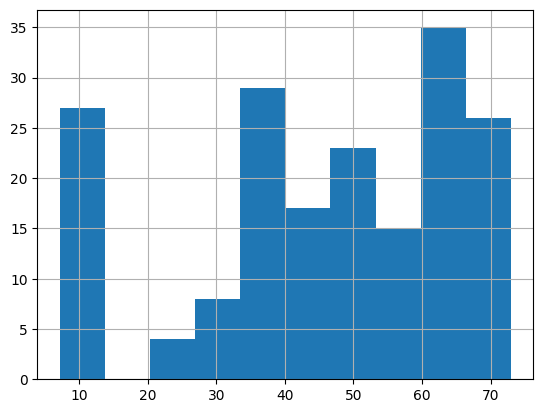

In [17]:
result['Popularity'].hist()

# Load Feature distribution

In [77]:
from datetime import datetime
nowyear = datetime.now().year
nowyear = str(nowyear) + '-01-01'
nowyear = '\'' + nowyear +'\''
type(nowyear)

str

In [48]:
%%bigquery update
SELECT t3.danceability, t3.energy,t3.key, t3.loudness, t3.mode, t3.speechiness, t3.acousticness, t3.instrumentalness, t3.liveness, t3.valence, t3.tempo, t3.duration_ms, t3.time_signature
FROM snappy-boulder-378707.History.Tracks as t1
inner join snappy-boulder-378707.History.Albums as t2
on t1.album_id = t2.id 
inner join snappy-boulder-378707.History.AudioFeatures as t3
on t1.id = t3.id
where t2.release_date >= '2023-01-01'

Query is running:   0%|          |

Downloading:   0%|          |

In [17]:
featuredistribution

,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,total_tracks
0,2023,0.572895,0.505717,5.261931,-10.775899,0.62716,0.08444,0.452873,0.308731,0.16713,0.406596,117.912214,197101.245016,3.887036,8277


In [25]:
result = list(update.apply(np.mean, axis=0))

In [27]:
result = [nowyear] + result + [len(update)]


In [29]:
%%bigquery
DELETE FROM snappy-boulder-378707.History.FeatureDistribution where year = 2023

Query is running:   0%|          |

""


In [36]:
q = ','.join(str(value) for value in result)
q = '(' + q + ')'

In [30]:
featuredistribution.columns

Index(['year', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'total_tracks'],
      dtype='object')

In [43]:
query = '''INSERT INTO snappy-boulder-378707.History.FeatureDistribution (year, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness,valence, tempo, duration_ms, time_signature, total_tracks)
       VALUES''' + q

In [44]:
query

'INSERT INTO snappy-boulder-378707.History.FeatureDistribution (year, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness,valence, tempo, duration_ms, time_signature, total_tracks)\n       VALUES(2023,0.5731648810953639,0.5058281138722076,5.264712947393707,-10.760300624549602,0.6270718232044199,0.08452648330530868,0.452614318607975,0.30748455190727836,0.1670467091040115,0.40648562334854665,117.91191796781168,197012.58479461927,3.887581071342782,8326)'

In [45]:
update = client.query(query)
update.result()

In [46]:
result

[2023,
 0.5731648810953639,
 0.5058281138722076,
 5.264712947393707,
 -10.760300624549602,
 0.6270718232044199,
 0.08452648330530868,
 0.452614318607975,
 0.30748455190727836,
 0.1670467091040115,
 0.40648562334854665,
 117.91191796781168,
 197012.58479461927,
 3.887581071342782,
 8326]

In [80]:
extraction = '''SELECT t3.danceability, t3.energy,t3.key, t3.loudness, t3.mode, t3.speechiness, t3.acousticness, t3.instrumentalness, t3.liveness, t3.valence, t3.tempo, t3.duration_ms, t3.time_signature
            FROM snappy-boulder-378707.History.Tracks as t1
            inner join snappy-boulder-378707.History.Albums as t2
            on t1.album_id = t2.id 
            inner join snappy-boulder-378707.History.AudioFeatures as t3
            on t1.id = t3.id
            where t2.release_date >= ''' + nowyear
update = client.query(extraction).to_dataframe()

In [81]:
update

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.751,0.492,0,-10.485,0,0.0505,0.6780,0.007830,0.1030,0.670,124.095,171264,5
1,0.466,0.409,0,-6.049,0,0.0904,0.8140,0.000000,0.1620,0.387,95.501,200088,4
2,0.674,0.924,0,-4.943,0,0.1020,0.0143,0.000006,0.2160,0.811,123.040,240053,4
3,0.315,0.102,0,-17.621,0,0.0340,0.9850,0.051200,0.1090,0.185,169.690,206723,3
4,0.825,0.124,0,-11.175,0,0.0706,0.8000,0.000003,0.2430,0.286,104.724,230333,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8321,0.506,0.789,11,-7.937,1,0.1030,0.0451,0.019800,0.0577,0.850,172.061,190850,4
8322,0.631,0.487,11,-5.226,1,0.0254,0.5460,0.000000,0.3030,0.564,131.962,201191,4
8323,0.756,0.921,11,-6.196,0,0.0508,0.0386,0.054600,0.3270,0.384,124.981,134880,4
8324,0.756,0.133,11,-9.792,0,0.0526,0.9770,0.825000,0.1330,0.451,65.736,145500,4


In [8]:
popularity_diff = client.query('''
SELECT t1.id, t1.name, t1.popularity as current_popularity,
t2.popularity as future_popularity, (t2.popularity - t1.popularity) as popularity_diff
FROM `snappy-boulder-378707.NewReleases.NewTracks`  as t1
inner join snappy-boulder-378707.NewReleases.PopularityPrediction as t2
on t1.id = t2.id''').to_dataframe()
genre_predicted =  client.query('SELECT * FROM snappy-boulder-378707.NewReleases.GenrePrediction').to_dataframe()
new_audio_features =  client.query('SELECT * FROM snappy-boulder-378707.NewReleases.NewAudioFeatures').to_dataframe()

In [ ]:
def highlight_mean_greater(s):
    '''
    highlight yellow is value is greater than mean else red.
    '''
    is_max = s > s.mean()
    return ['background-color: yellow' if i else 'background-color: red' for i in is_max]

In [ ]:
cm = sns.light_palette("green", as_cmap=True)
popularity_diff.style.background_gradient(cmap=cm, subset=['popularity_diff']).highlight_max(subset=['current_popularity','future_popularity','popularity_diff'], ).set_caption('This is a custom caption.')

In [50]:
popularity_diff.style.bar(subset=["popularity_diff",], color='lightgreen')

,id,name,current_popularity,future_popularity,popularity_diff
0,4QLqCFAGqvHnjOWCtHTsQL,Veronica Mars,43,45,2
1,7f1mKhZ8s6di51f76Qf03E,Kiss City,39,46,7
2,2pqi703QQcp2zsuS3NgCii,Olympus,39,43,4
3,4wHo9RDSY0elxbeiMpYNLN,Salad,37,44,7
4,1oMceEpywwehJQWKGueTlc,Sepsis,35,45,10
5,27q2n59NonHyzNMKXzmaFX,Joiner,34,44,10
6,23ftRN9rp1u4wd0pADRchT,Tarmac,33,45,12
7,2fFZuSK5yTfs0gVuwQAldc,Dangerous,33,42,9
8,4xo2cd0kmp3GO1jZzAst1D,Can I Jump?,59,53,-6
9,4feAlo2wgcAtOx6ED9jw2q,Face in the Crowd,35,47,12


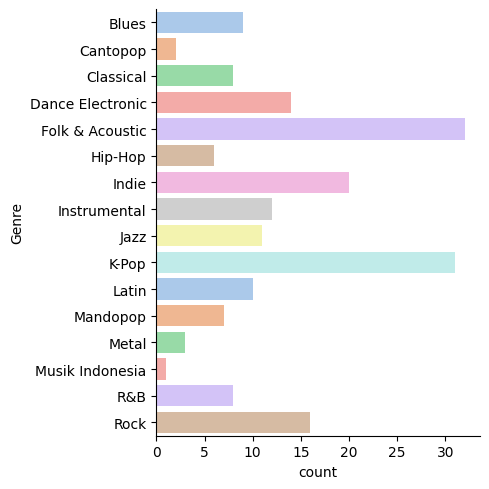

In [48]:

g = sns.catplot(y = 'Genre',kind="count",data = genre_predicted, palette="pastel")
fig, ax = g.fig, g.ax